In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def generate_random_ar_simple(
    n=4000, p_min=2, p_max=12,
    weight_scale=0.25, noise_std=0.5,
    burn_in=300, seed=0, standardize=True,
    fs=200, verbose=True,
):
    rng = np.random.default_rng(seed)
    p_true = int(rng.integers(p_min, p_max + 1))
    a_true = rng.normal(0.0, weight_scale, size=p_true)

    total = n + burn_in
    x = np.zeros(total, dtype=float)
    eps = rng.normal(0.0, noise_std, size=total)
    x[:p_true] = rng.normal(0.0, noise_std, size=p_true)

    for t in range(p_true, total):
        lags = x[t-p_true:t][::-1]  # [x_{t-1},...,x_{t-p}]
        x[t] = float(np.dot(a_true, lags) + eps[t])

    x = x[burn_in:]
    if standardize:
        x = (x - x.mean()) / (x.std() + 1e-12)

    if verbose:
        print(f"[GEN] true p = {p_true}")
        print(f"[GEN] true a (len={p_true}) = {a_true}")
        print(f"[GEN] fs = {fs} Hz")

    return x, {"p_true": p_true, "a_true": a_true, "fs": fs}

In [3]:
x, info = generate_random_ar_simple(
    n=6000, p_min=2, p_max=20,
    weight_scale=0.4, noise_std=0.6,
    standardize=False,
    seed=42
)
fs = info["fs"]
print(x, info["p_true"], info["a_true"])

[GEN] true p = 3
[GEN] true a (len=3) = [-0.41599364  0.30018048  0.37622589]
[GEN] fs = 200 Hz
[ 0.33673095 -0.54843297 -0.27128372 ... -1.03846436  0.38786951
 -0.68774516] 3 [-0.41599364  0.30018048  0.37622589]


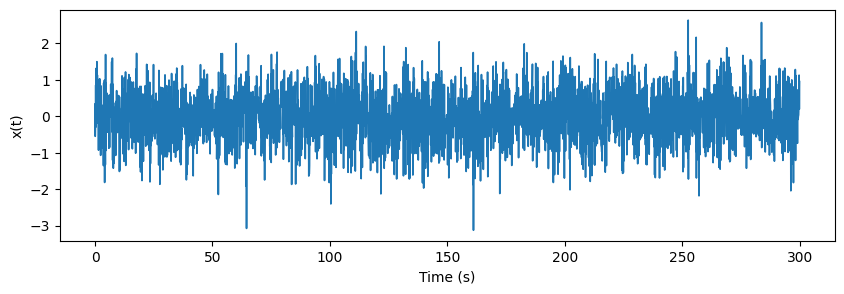

In [4]:
t = np.arange(0, 6000) / 10
plt.figure(figsize=(10, 3))
plt.plot(t[0:3000], x[0:3000], linewidth=1.2)
plt.xlabel(f"Time (s)")
plt.ylabel("x(t)")
plt.show()

In [5]:
def make_lagged_dataset(x, Pmax):
    x = np.asarray(x)
    T = len(x)
    X = np.stack([x[Pmax-k:T-k] for k in range(1, Pmax+1)], axis=1)  # (T-Pmax, Pmax)
    y = x[Pmax:]                                                     # (T-Pmax,)
    return X, y

In [6]:
class TransformerAR(nn.Module):
    def __init__(self, Pmax, d_model=64, nhead=4, depth=2, dropout=0.1):
        super().__init__()
        self.Pmax = Pmax
        self.d_model = d_model

        self.in_proj = nn.Linear(1, d_model)

        # learned positional embeddings for lag positions 0..Pmax-1
        self.pos = nn.Parameter(torch.zeros(1, Pmax, d_model))
        nn.init.normal_(self.pos, mean=0.0, std=0.02)

        # CLS token to summarize the whole lag sequence
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, mean=0.0, std=0.02)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.out = nn.Linear(d_model, 1)

    def forward(self, X_seq):
        """
        X_seq: (B, Pmax, 1) where position 0 is x_{t-1}, position 1 is x_{t-2}, ...
        """
        h = self.in_proj(X_seq) + self.pos                 # (B, Pmax, d)
        cls = self.cls.expand(X_seq.size(0), 1, -1)         # (B, 1, d)
        h = torch.cat([cls, h], dim=1)                      # (B, 1+Pmax, d)

        h = self.encoder(h)                                 # (B, 1+Pmax, d)
        h_cls = h[:, 0, :]                                  # (B, d)
        yhat = self.out(h_cls).squeeze(-1)                   # (B,)
        return yhat

In [ ]:
def train_ar_transformer(
    x, Pmax,
    d_model=64, nhead=4, depth=2, dropout=0.05,
    lr=2e-3, weight_decay=1e-4,
    epochs=300, batch_size=256,
    eval_every=10, patience=30,
    seed=0, device=None,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)
    np.random.seed(seed)

    X, y = make_lagged_dataset(x, Pmax)          # X: (N, Pmax), y: (N,)
    N = len(y)

    # time-ordered split (60/20/20)
    n_tr = int(0.6 * N)
    n_va = int(0.2 * N)
    tr_slice = slice(0, n_tr)
    va_slice = slice(n_tr, n_tr + n_va)
    te_slice = slice(n_tr + n_va, N)

    X_tr, y_tr = X[tr_slice], y[tr_slice]
    X_va, y_va = X[va_slice], y[va_slice]
    X_te, y_te = X[te_slice], y[te_slice]

    # standardize using TRAIN only (features + target)
    X_mean = X_tr.mean(axis=0, keepdims=True)
    X_std  = X_tr.std(axis=0, keepdims=True) + 1e-8
    y_mean = y_tr.mean()
    y_std  = y_tr.std() + 1e-8

    X_tr_s = (X_tr - X_mean) / X_std
    X_va_s = (X_va - X_mean) / X_std
    X_te_s = (X_te - X_mean) / X_std
    y_tr_s = (y_tr - y_mean) / y_std
    y_va_s = (y_va - y_mean) / y_std
    y_te_s = (y_te - y_mean) / y_std

    # reshape into sequences (B, Pmax, 1)
    def to_seq(a):
        return a.astype(np.float32).reshape(-1, Pmax, 1)

    X_tr_t = torch.from_numpy(to_seq(X_tr_s))
    X_va_t = torch.from_numpy(to_seq(X_va_s))
    X_te_t = torch.from_numpy(to_seq(X_te_s))
    y_tr_t = torch.from_numpy(y_tr_s.astype(np.float32))
    y_va_t = torch.from_numpy(y_va_s.astype(np.float32))
    y_te_t = torch.from_numpy(y_te_s.astype(np.float32))

    tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=batch_size, shuffle=True, drop_last=False)
    va_loader = DataLoader(TensorDataset(X_va_t, y_va_t), batch_size=batch_size, shuffle=False, drop_last=False)
    te_loader = DataLoader(TensorDataset(X_te_t, y_te_t), batch_size=batch_size, shuffle=False, drop_last=False)

    model = TransformerAR(Pmax, d_model=d_model, nhead=nhead, depth=depth, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best = {"val": float("inf"), "state": None, "epoch": -1}
    bad = 0

    @torch.no_grad()
    def eval_mse(loader):
        model.eval()
        tot, cnt = 0.0, 0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            bs = xb.size(0)
            tot += loss.item() * bs
            cnt += bs
        return tot / max(cnt, 1)

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in tr_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        if ep % eval_every == 0 or ep == 1:
            val = eval_mse(va_loader)
            if val < best["val"] - 1e-6:
                best["val"] = val
                best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                best["epoch"] = ep
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    break

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    val_mse = eval_mse(va_loader)
    te_mse  = eval_mse(te_loader)

    # convenience prediction function (returns unstandardized predictions)
    @torch.no_grad()
    def predict_np(X_raw):
        """
        X_raw: (N, Pmax) raw lags (unstandardized)
        returns yhat in original scale
        """
        Xs = (X_raw - X_mean) / X_std
        Xs = Xs.astype(np.float32).reshape(-1, Pmax, 1)
        xb = torch.from_numpy(Xs).to(device)
        model.eval()
        yhat_s = model(xb).detach().cpu().numpy()
        return yhat_s * y_std + y_mean

    scalers = {"X_mean": X_mean, "X_std": X_std, "y_mean": y_mean, "y_std": y_std}
    splits = {
        "X_tr": X_tr, "y_tr": y_tr,
        "X_va": X_va, "y_va": y_va,
        "X_te": X_te, "y_te": y_te,
    }
    metrics = {"val_mse_standardized": val_mse, "test_mse_standardized": te_mse, "best_epoch": best["epoch"]}
    return model, predict_np, scalers, splits, metrics

# def sweep_p_transformer(x, p_range, **train_kwargs):
#     results = {}
#     for p in p_range:
#         model, predict_np, scalers, splits, metrics = train_ar_transformer(
#             x, Pmax=p, **train_kwargs
#         )
#         results[p] = {"metrics": metrics}
#         print(f"p={p:2d} | val={metrics['val_mse_standardized']:.4f} "
#                 f"| test={metrics['test_mse_standardized']:.4f} "
#                 f"| best_ep={metrics['best_epoch']}")
#     return results

def sweep_p_transformer(x, p_range, **train_kwargs):
    results = {}
    for p in p_range:
        model, predict_np, scalers, splits, metrics = train_ar_transformer(
            x, Pmax=p, **train_kwargs
        )
        results[p] = {
            "model": model,
            "predict_np": predict_np,
            "scalers": scalers,
            "splits": splits,
            "metrics": metrics,
        }
        print(f"p={p:2d} | val={metrics['val_mse_standardized']:.4f} "
              f"| test={metrics['test_mse_standardized']:.4f} "
              f"| best_ep={metrics['best_epoch']}")
    return results

In [8]:
def estimate_effective_ar_weights(model, scalers, X_raw_batch, device=None):
    """
    model: trained TransformerAR
    scalers: dict with X_mean, X_std, y_std
    X_raw_batch: (B, Pmax) raw lags in original units
    returns: (Pmax,) estimated d yhat / d x_{t-1..t-Pmax} averaged over the batch
    """
    if device is None:
        device = next(model.parameters()).device

    X_mean = scalers["X_mean"]
    X_std  = scalers["X_std"]
    y_std  = scalers["y_std"]

    # standardize inputs like training
    Xs = (X_raw_batch - X_mean) / X_std
    Xs = Xs.astype(np.float32).reshape(-1, model.Pmax, 1)

    xb = torch.tensor(Xs, device=device, requires_grad=True)
    model.eval()
    yhat_s = model(xb)                    # standardized prediction (since model trained on y_s)

    # sum to get a scalar for autograd
    ysum = yhat_s.sum()
    ysum.backward()

    # grad wrt standardized input tokens (B, Pmax, 1)
    grad_Xs = xb.grad.detach().cpu().numpy().reshape(-1, model.Pmax)  # dy_s/dX_s

    # chain rule to map to original scale:
    # y = y_std * y_s + y_mean  => dy/dy_s = y_std
    # X_s = (X - mean)/std      => dX_s/dX = 1/std
    # so dy/dX = y_std * dy_s/dX_s * (1/std)
    eff = (y_std * grad_Xs) * (1.0 / X_std.reshape(1, -1))
    return eff.mean(axis=0)

In [12]:
results[3]

{'metrics': {'val_mse_standardized': 0.6969089103898374,
  'test_mse_standardized': 0.7485223642985026,
  'best_epoch': 70}}

In [10]:
p_range = range(1, 21)
results = sweep_p_transformer(
    x, p_range,
    d_model=64, nhead=4, depth=2, dropout=0.05,
    lr=2e-3, weight_decay=1e-4,
    epochs=300, batch_size=256,
    eval_every=10, patience=30,
    seed=0, device=None
)

best_p = min(results, key=lambda p: results[p]["metrics"]["val_mse_standardized"])
print("Best p =", best_p)

best_model = results[best_p]["model"]
best_scalers = results[best_p]["scalers"]
best_splits = results[best_p]["splits"]



/Users/novak/miniforge3/envs/armodeling/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


p= 1 | val=0.7888 | test=0.8756 | best_ep=260


/Users/novak/miniforge3/envs/armodeling/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


p= 2 | val=0.7725 | test=0.8634 | best_ep=290
p= 3 | val=0.6969 | test=0.7485 | best_ep=70
p= 4 | val=0.7078 | test=0.7457 | best_ep=20
p= 5 | val=0.7024 | test=0.7709 | best_ep=70
p= 6 | val=0.6972 | test=0.7565 | best_ep=60
p= 7 | val=0.7121 | test=0.7675 | best_ep=10
p= 8 | val=0.7066 | test=0.7650 | best_ep=40
p= 9 | val=0.7069 | test=0.7615 | best_ep=50
p=10 | val=0.6975 | test=0.7630 | best_ep=40
p=11 | val=0.7014 | test=0.7572 | best_ep=70
p=12 | val=0.6996 | test=0.7626 | best_ep=30
p=13 | val=0.7009 | test=0.7656 | best_ep=40
p=14 | val=0.6999 | test=0.7630 | best_ep=30
p=15 | val=0.7046 | test=0.7587 | best_ep=40
p=16 | val=0.7065 | test=0.7629 | best_ep=40
p=17 | val=0.6981 | test=0.7585 | best_ep=30
p=18 | val=0.7086 | test=0.7607 | best_ep=40
p=19 | val=0.7068 | test=0.7586 | best_ep=50
p=20 | val=0.7002 | test=0.7720 | best_ep=40
Best p = 3


KeyError: 'model'

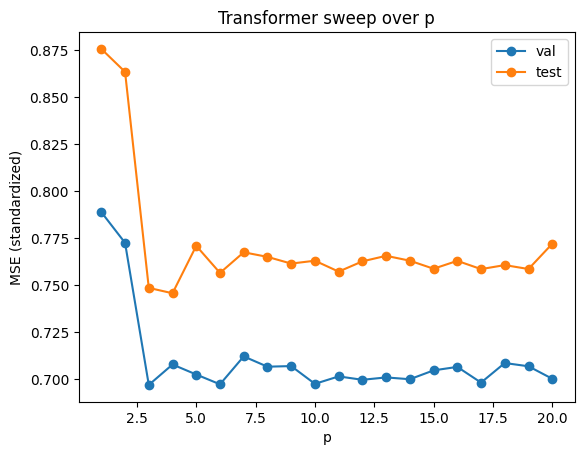

In [13]:
ps = sorted(results.keys())
val = [results[p]["metrics"]["val_mse_standardized"] for p in ps]
tes = [results[p]["metrics"]["test_mse_standardized"] for p in ps]

plt.figure()
plt.plot(ps, val, marker="o", label="val")
plt.plot(ps, tes, marker="o", label="test")
plt.xlabel("p")
plt.ylabel("MSE (standardized)")
plt.legend()
plt.title("Transformer sweep over p")
plt.show()

In [15]:
best_p = 3
best_model, best_predict, best_scalers, best_splits, best_metrics = train_ar_transformer(
    x, Pmax=best_p,
    d_model=64, nhead=4, depth=2, dropout=0.05,
    lr=2e-3, weight_decay=1e-4,
    epochs=300, batch_size=256,
    eval_every=10, patience=30,
    seed=0, device=None
)

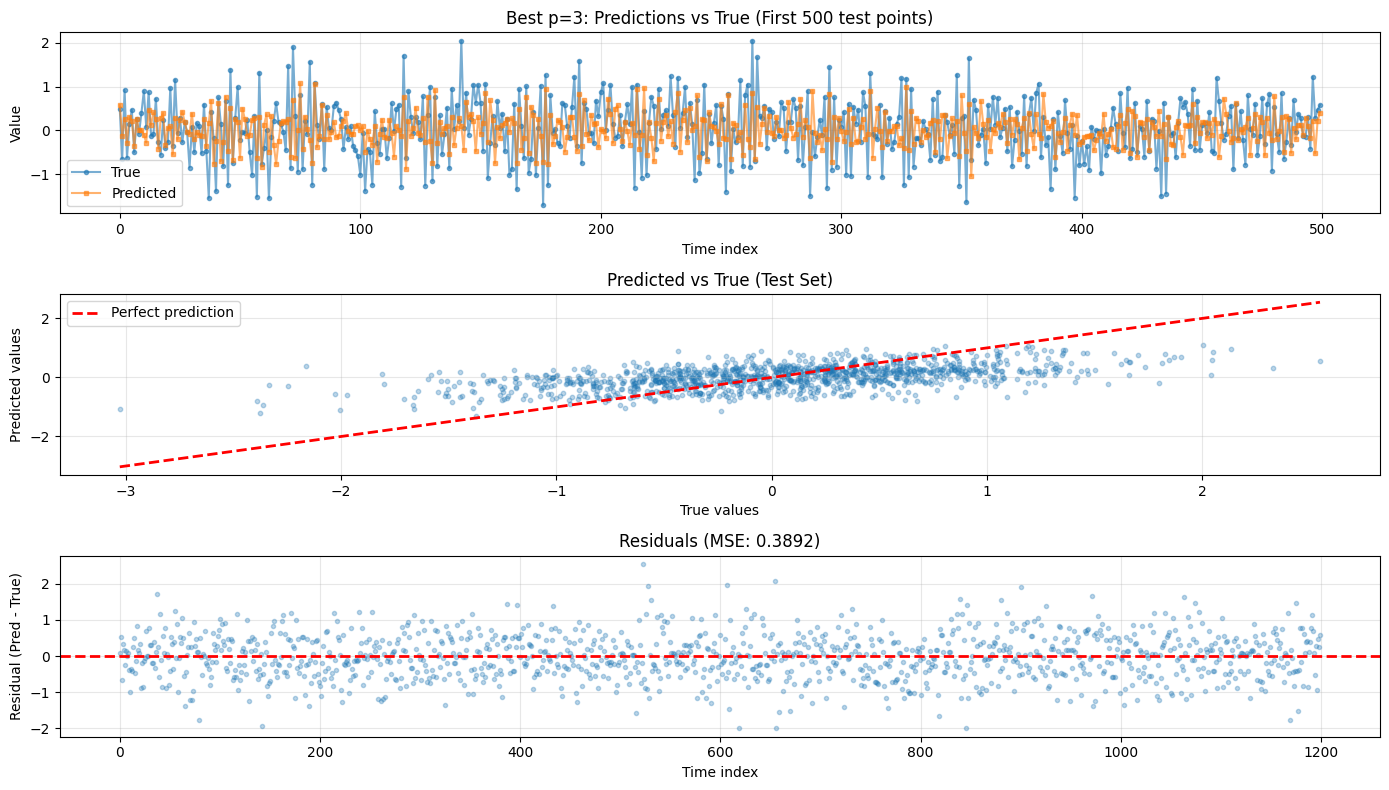

Correlation between predicted and true: 0.5325


In [16]:
# 1) pick best p
# best_p = min(results, key=lambda p: results[p]["metrics"]["val_mse_standardized"])
# print("Best p =", best_p, "| val =", results[best_p]["metrics"]["val_mse_standardized"],
#       "| test =", results[best_p]["metrics"]["test_mse_standardized"])

# # 2) unpack best run objects
# best_model   = results[best_p]["model"]
# best_predict = results[best_p]["predict_np"]
# best_scalers = results[best_p]["scalers"]
# best_splits  = results[best_p]["splits"]

# 3) get test data for best p
X_te = best_splits["X_te"]
y_true = best_splits["y_te"]

# 4) predictions (in original scale)
y_pred = best_predict(X_te)

# 5) plots
t_test = np.arange(len(y_true))

plt.figure(figsize=(14, 8))

# Plot 1: time series overlay
plt.subplot(3, 1, 1)
plt.plot(t_test[:500], y_true[:500], 'o-', label='True', alpha=0.6, markersize=3)
plt.plot(t_test[:500], y_pred[:500], 's-', label='Predicted', alpha=0.6, markersize=3)
plt.xlabel('Time index')
plt.ylabel('Value')
plt.title(f'Best p={best_p}: Predictions vs True (First 500 test points)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: scatter
plt.subplot(3, 1, 2)
plt.scatter(y_true, y_pred, alpha=0.3, s=10)
mn = min(y_true.min(), y_pred.min())
mx = max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: residuals
residuals = y_pred - y_true
plt.subplot(3, 1, 3)
plt.plot(t_test, residuals, 'o', alpha=0.3, markersize=3)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Time index')
plt.ylabel('Residual (Pred - True)')
plt.title(f'Residuals (MSE: {np.mean(residuals**2):.4f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6) correlation
print(f"Correlation between predicted and true: {np.corrcoef(y_pred, y_true)[0,1]:.4f}")

In [17]:
# # Get predictions on test set
# y_pred = predict_np(X_te)
# y_true = splits["y_te"]

# # Create time indices for test set
# t_test = np.arange(len(y_true))

# plt.figure(figsize=(14, 8))

# # Plot 1: Predictions vs True values over time
# plt.subplot(3, 1, 1)
# plt.plot(t_test[:500], y_true[:500], 'o-', label='True', alpha=0.6, markersize=3)
# plt.plot(t_test[:500], y_pred[:500], 's-', label='Predicted', alpha=0.6, markersize=3)
# plt.xlabel('Time index')
# plt.ylabel('Value')
# plt.title('Predictions vs True Values (First 500 test points)')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Scatter plot of predictions vs true
# plt.subplot(3, 1, 2)
# plt.scatter(y_true, y_pred, alpha=0.3, s=10)
# plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect prediction')
# plt.xlabel('True values')
# plt.ylabel('Predicted values')
# plt.title('Predicted vs True (Test Set)')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 3: Residuals
# residuals = y_pred - y_true
# plt.subplot(3, 1, 3)
# plt.plot(t_test, residuals, 'o', alpha=0.3, markersize=3)
# plt.axhline(0, color='r', linestyle='--', lw=2)
# plt.xlabel('Time index')
# plt.ylabel('Residual (Pred - True)')
# plt.title(f'Prediction Residuals (MSE: {np.mean(residuals**2):.4f})')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print correlation
# print(f"Correlation between predicted and true: {np.corrcoef(y_pred, y_true)[0,1]:.4f}")

# # Print true vs estimated AR weights
# print("\n" + "="*60)
# print("AR Weight Comparison")
# print("="*60)

# print(f"  True:      {a_pad[:p_true]}")
# print(f"  Estimated: {eff_w[:p_true]}")